In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import odeint
import fourierModel as fm
from matplotlib import animation
from IPython.display import HTML

from datetime import date

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
#File management parameters
#Qualifier tag for file names #should include what makes this figure unique
tag = "" ### NOTE: if you do not change the tag between runs on the same day you will overwrite the previous run: try to use a descriptive tag
todays_date = date.today().strftime("%d-%m-%Y")

#File writer for saving animations as gifs
writergif = animation.PillowWriter(fps=480) 

#optional for saving as mp4, (or anim or mpg) but requires ffmpeg

writervideo = animation.FFMpegWriter(fps=60) #make sure files end in .mp4 oetc.

In [4]:
# These are run control parameters
""" Fliq is the QLL (shape: nx)
    Ntot is the the combined values of the ice layers (Nice), combined with the QLL layer (Nliq or Fliq or NQLL variously referred to as)
        Ntot is shaped (2, nx)
"""


noisy_init = False
noise_std_dev = 0.01

# Flag for explicit updating Fliq(Ntot) every step 
updatingFliq = True
# Set up a maximum number of iterations or layers
uselayers = True

if uselayers:
    layermax_0D = 20 #####
    layermax_1D = 500 ####
else:
    countermax_0D = 100
    countermax_1D = 15000

In [5]:
#Setting up the system
# Number of iterations to calculate Nliq from Ntot (Increased niter means more iterative calculation: converges on greater accuracy at cost of time)
niter = 1

#new system
nx = 500 # Number of points in simulation box
xmax = 50 # range of x
x = np.linspace(0, xmax, nx)

deltaX = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)

# Initialize as a pre-equilibrated layer of liquid over ice
Nice = np.ones(nx)

if noisy_init:
    # Initialize with noise
    noise = np.random.normal(0,noise_std_dev,nx)
    Nice += noise


Fliq = ds.getNliq_array(Nice,Nstar,Nbar,niter)

# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
nquart = int(nx/4)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
#Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const #NOTE: this is unused

In [6]:
#Time and diffusion parameters
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 10
dtmaxtimefactor = 50
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth


#Chanign params for reproducing simulation
#sigmastepmax = -0.1

center_reduction = 0.25 # In percent
#center_reduction = 0.1 
c_r = center_reduction/100


# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Gets the function sigma(x)
sigmastep = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax) #NOTE i think this should be nx not xmax
#sigmastep_parabolic = ds.getsigmastep(x,xmax,center_reduction,sigmastepmax,method='parabolic')
#sigmastepstyle = 'parabolic'
#if sigmastepstyle=='sinusoid':
#    sigmastep = sigmastep_sinusoid
#elif sigmastepstyle=='parabolic':
#    sigmastep = sigmastep_parabolic
#else:
#    print('bad choice')

# # Graph sigma(x)
# fignum +=1
# plt.figure(fignum)
# plt.plot(x-xmid,sigmastep_sinusoid/sigmastepmax, \
#          x-xmid, sigmastep_parabolic/sigmastepmax, '--',lw=linewidth)
# plt.xlim([-xmid,xmid])
# plt.legend(['sinusoidal ', 'parabolic'])
# plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
# plt.grid('on')

In [7]:
# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltaT_max (Diffusion time)', dtmax)
print('deltaT =', deltaT)
print('deprate =', deprate, 'monolayers/us')
print('nmid', nmid)
print('N*', Nstar)
print('N*x2pi', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltaX', deltaX)
print('sigma_0 =', sigma0)
print('sigmastepmax =', sigmastepmax)
print('center reduction', center_reduction, '%')
print('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.20060160400962
deltaT = 1.0040120320801924
deprate = 0.16333333333333333 monolayers/us
nmid 250
N* 0.1432394487827058
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.8567605512172942 0.1432394487827058
deltaX 0.10020040080160321
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction 0.25 %
max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
nu_kin = 49 um/sec


In [8]:
# This is the 0-d run
# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmastepmax, sigma0, deprate])

y0 = [Nbar,0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep_0D = [t0]
ykeep_0D = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Ntotlast0 = 0.0
Nicelast_start = 0.0
Ntotlast_start = 0.0

# Call the ODE solver
counter = 0
layer = 0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,niter))
    ylast = list(y[1,:])
    tlast += deltaT
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast

    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep_0D[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    Ntotlast0 = dup(Ntotlast)
    
    # Update counters and see whether to break
    counter += 1
    layer = dup(Ntotlast0) 
    # See whether to break
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_0D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_0D:
                print('breaking because reached max number of layers ablated')
                break 
    else:
        if counter > countermax_0D-1:
            break
    
# Convert results to a numpy array
ykeep_0Darr = np.array(ykeep_0D, np.float64)
tkeep_0Darr = np.array(tkeep_0D, np.float64)
# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0Darr[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')

# Growth statistics
delta_Ntot_0d = Ntotlast0-Ntotlast_start
growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0d)
print( "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus)
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print( "0-D Modeled alpha", alpha_0d)


TypeError: No matching definition for argument type(s) array(float64, 1d, C), float64, array(float64, 1d, C), int64

In [ ]:
#Parameters for 1-D run 
L = xmax/2; print(L) # micrometers
c_r = center_reduction / 100; print(c_r) # dimensionless
nu_kin_ml = deprate; print(nu_kin_ml) # monolayers per microsecond
sigma_I = sigmastepmax; print(sigma_I) # dimensionless
print(D) # D is in micrometers^2/microsecond
M = np.array([.0027, .0025])
B = np.array([2.9, 1.59])
beta = np.array([0.65, 0.65])
xfactor = nu_kin_ml*L**2*c_r**beta*sigma_I/D
NSS = M*xfactor + B
print('Nss predicted')
print('sinusoid:', NSS[0])
print('paraboloic:', NSS[1])

In [ ]:
# This is the 1-d run
#Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx = params #original params
# Bundle parameters for ODE solver
float_params = np.array([Nbar, Nstar, sigma0, deprate, DoverdeltaX2])
int_params = np.array([niter,nx])

print([type(i) for i in int_params])


# Initial conditions for ODE solver
y0 = np.array([Fliq,Ntot])
ylast = dup(y0)

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [dup(Nice)]
Ntotkeep = [dup(Ntot)]
Fliqkeep = [dup(Fliq)]
fluxderivskeep = []

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
Ntot0_start = Ntot[0]
Ntot0 = Ntot[0]
updatingFliq = True
counter = 0
lastlayer = 0
lastdiff = 0
while True:
    # Integrate up to next time step
    y = odeint(ds.f1d,np.reshape(ylast,2*nx),  tinterval,  args=(float_params,int_params,sigmastep),rtol=1e-12)

    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq_array(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    Ntot0 = Ntot[0]
    ttot += deltaT

    # Stuff into keeper arrays for animations
    Nicekeep.append(Nice)
    Ntotkeep.append(Ntot)
    Fliqkeep.append(Fliq)
    tkeep.append(ttot)

    # Update counters and see whether to break
    layer = Ntot0-Ntot0_start
    if (layer-lastlayer) > 0:
        minpoint = min(Nice)
        maxpoint = max(Nice)
        print(counter-1, lastlayer, maxpoint-minpoint, maxpoint-minpoint-lastdiff)
        lastdiff = maxpoint-minpoint
        lastlayer += 1
        
    # Test whether we're finished
    if uselayers:
        if sigmastepmax > 0:
            if layer > layermax_1D-1:
                print('breaking because reached max number of layers grown')
                break
        else:
            if layer < -layermax_1D:
                print('breaking because reached max number of layers ablated')
                break
    else:
        if counter > countermax_1D-1:
            print('breaking because reached max number of iterations')
            break

In [ ]:
# Growth statistics
minpoint = min(Nice)
ncorner = 4 # why is ncorner 4 and not 0?

# total height of ice
print("Height of Ice", minpoint)

 # change in total ice depth at each grid point
delta_Ntot_entire = Ntot-Ntotkeep[0]

# growth at corner and in center
print( "1-D growth, corner", delta_Ntot_entire[ncorner])
print( "1-D growth, center", delta_Ntot_entire[nmid])

# growth over time (growth rate)
growthrate_entire = delta_Ntot_entire/ttot*umpersec_over_mlyperus
print( "1-D Modeled growth rate, corner, um/s", growthrate_entire[ncorner])
print( "1-D Modeled growth rate, corner, ml/us", growthrate_entire[ncorner]/umpersec_over_mlyperus) # why different units on this one?
print( "1-D Modeled growth rate, center, um/s", growthrate_entire[nmid])

# alpha is some other modified growth rate
alpha = growthrate_entire/nu_kin/sigmastep
print( "1-D Modeled alpha, corner", alpha[ncorner])
print( "1-D Modeled alpha, center", alpha[nmid])
print( "Difference, %", (alpha[nmid]-alpha[ncorner])/alpha[ncorner]*100)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print("Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax)
print("Libbrecht's predicted alpha", alpha_L)

In [37]:
#1d ablation run
from sim_handling import Simulation
from diffusionstuff7 import f1d
 #set up and run and plot a new simulation
ablation_1d_sim = Simulation(f1d, (500,), method='RK45', rtol=1e-12)
#test_1d_asym = Simulation(f1d, (500,), method='LSODA')

ablation_1d_sim.discretization_halt = False

#try a noisy simulation
ablation_1d_sim.noisy_init = False

ablation_1d_sim.layermax = 2000
ablation_1d_sim.sigmastepmax= -0.01 #ablation



In [38]:
Ntotkeep = ablation_1d_sim.getNtot()
Nicekeep = ablation_1d_sim.getNice()
tkeep = np.linspace(0, len(Ntotkeep), len(Ntotkeep))

breaking because reached max number of layers ablated


In [39]:
tag ='ablation'
print(len(Ntotkeep))

70845


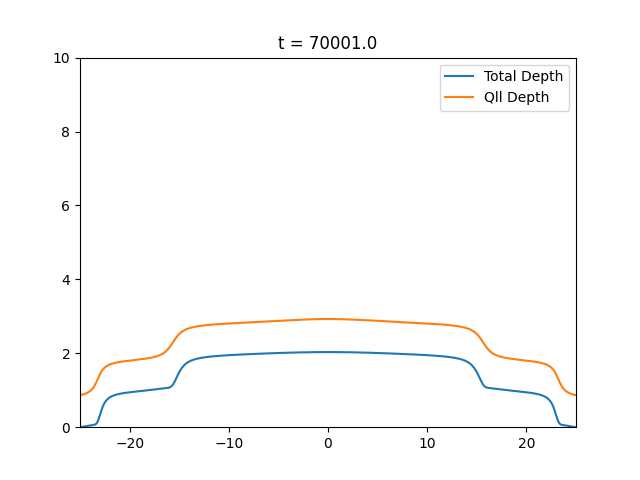

C:\Users\Max-PC\AppData\Local\Temp\ipykernel_3520\2897093501.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(min(Niceanim[n]-min(Niceanim[n])), max(Niceanim[n]-min(Niceanim[n])))
C:\Users\Max-PC\AppData\Local\Temp\ipykernel_3520\2897093501.py:24: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(min(Niceanim[n]-min(Niceanim[n])), max(Niceanim[n]-min(Niceanim[n])))


In [40]:
# animation of facet depth over time

Ntotanim = Ntotkeep[0::1000]
Niceanim = Nicekeep[0::1000]
#Fliqanim = Fliqkeep[0::1000]
tanim = tkeep[0::1000]

# initialize figure
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = min(x-xmid),xmax = max(x-xmid),ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

legendList = ["Total Depth","Qll Depth"]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(x-xmid,Niceanim[n]-min(Niceanim[n]))
    lineList[1][0].set_data(x-xmid,Ntotanim[n]-min(Niceanim[n]))
    plt.title('t = '+str(round(tanim[n],1)))
    plt.legend(legendList, loc = "upper right")
    #plt.axes(ymin = min(Niceanim[n]), ymax = min(Niceanim[n])+10)
    #ax.set_ylim(min(Niceanim[n]-min(Niceanim[n])), min(Niceanim[n])+10)
    
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

#plt.close()

anim.save(todays_date+"_1D_"+tag+"_"+str(layermax_1D)+"layers.gif", writer=writergif)

HTML(anim.to_jshtml())

In [ ]:
# Plots - saved by default

# First plot: layers (rescaled to have minimum at zero, shifted so center of facet is at zero)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Nice-minpoint, 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Fliq+Nice-minpoint, 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')
plt.savefig(todays_date+"_"+tag+"1D_"+str(layermax_1D)+"layers.png", dpi=480)
print(plt.get_fignums())

# Second plot: liquid layer alone
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, Fliq, 'g', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.grid('on')
plt.savefig(todays_date+"_"+tag+"1D_"+str(layermax_1D)+"liquid.png", dpi=480)

# Third plot: alpha (a measure of growth rate at each point)
fignum +=1
plt.figure(fignum)
plt.plot(x-xmid, alpha, 'k', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ \alpha $',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.savefig(todays_date+"_"+tag+"1D_"+str(layermax_1D)+"alpha.png", dpi=480)

In [ ]:
N = 64
xRed = np.arange(0,50,50/(2*N-2))
sigmastepRed = ds.getsigmastep(xRed,xmax,center_reduction,sigmastepmax)#,method='parabolic')

FliqRed = fm.ifftnorm(fm.fftnorm(Fliq)[0:N])

delta = (FliqRed - (Nbar - Nstar))/(2*Nstar)
sigD = (sigmastepRed - delta * sigma0)/(1+delta*sigma0)
depsurf = deprate * sigD

params = {"N" : N,
          "Nstar" : Nstar,
          "nu_kin" : nu_kin,
          "depRate" : depsurf,
          "depRate_FFT" : fm.fftnorm(depsurf),
          "k" : np.arange(0,N),
          "D" : D,
          "ICNT" : Ntot,
          "ICNQLL" : Fliq,
          "endtime" : 10000,
          "timesteps" : np.arange(0,10000,100)}



out = fm.runSim(params)

In [ ]:
timesteps = out.y.shape[1]
    
NTot = np.zeros((timesteps,2*N-2))
NQLL = np.zeros((timesteps,2*N-2))
    
for i in range(timesteps):
    NTot[i,:] = fm.ifftnorm(out.y[0:N,i])
    NQLL[i,:] = fm.ifftnorm(out.y[N:,i])

In [ ]:
# initialize figure # weird fourier model animation
myFig = plt.figure()
ax = plt.subplot()
ax.axis(xmin = 0,xmax = 126,ymin = 0, ymax = 10)
# create empty list of lines to populate each iteration
lineList = [ax.plot([],[]) for i in range(2)]

# define function to draw each frame
def makeFrame(n):
    lineList[0][0].set_data(np.arange(0,NQLL[n,].shape[0]),NTot[n,]-np.max(NTot[n,]-NQLL[n,]))
    lineList[1][0].set_data(np.arange(0,NQLL[n,].shape[0]),NTot[n,]-NQLL[n,]-np.max(NTot[n,]-NQLL[n,]))
    plt.title('t = '+str(round(out.t[n],1)))
    return lineList

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(out.t))


#anim.save(todays_date+"_1D_"+tag+"_.gif", writer=writergif) #NOTE: TODO: what is this -max

plt.close()
HTML(anim.to_jshtml())